In [1]:
import pandas as pd
import numpy as np
import os; print(os.listdir())
import warnings; warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

['submission_sample.csv', 'test', 'MTH.ipynb', 'MidTermHack.ipynb', 'train', '.ipynb_checkpoints', 'Untitled.ipynb']


## Mid-Term Hackathon

### <b><span style='color:#686dec'>Задача</span></b>

Нам кужно определить тип опухоли по измерении и статистик опухоли и использовать нужно методы связаны с деревьями

### <b><span style='color:#686dec'>Загрузка Данных</span></b> 

- Признаки в разных файлах различаются, все они имеют общие признаки `ID`, `Category`
- Потребуется проверка пропусков, чтобы уточнить есть какие данные у нас есть для каждого `ID`
- Объеденим данные с помощью `concat`

In [2]:
# Объеденим наши данные
train = pd.concat([pd.read_csv("./train/train" + str(i) + ".csv") for i in range(5)], axis=1)
test = pd.concat([pd.read_csv("./test/test" + str(i) + ".csv") for i in range(5)], axis=1)
train.columns

Index(['ID', 'Category', 'radius_mean', 'radius_std', 'radius_max',
       'texture_mean', 'texture_std', 'IT', 'Category', 'area_std', 'area_max',
       'smoothness_mean', 'smoothness_std', 'smoothness_max',
       'compactness_mean', 'compactness_std', 'compactness_max',
       'concavity_mean', 'concavity_std', 'concavity_max', 'ID', 'Category',
       'concave_points_mean', 'concave_points_std', 'concave_points_max',
       'symmetry_mean', 'symmetry_std', 'symmetry_max', '1D', 'Category',
       'texture_max', 'perimeter_mean', 'perimeter_std', 'perimeter_max',
       'area_mean', 'ID', 'Category', 'fractal_dimension_mean',
       'fractal_dimension_std', 'fractal_dimension_max'],
      dtype='object')

### <b><span style='color:#686dec'>Пропуски в Данных</span></b>

- Посмотрим, есть ли пропуски

In [3]:
# Пропусков у нас нет
print('missing train:',train.isna().sum().sum())
print('missing test:',test.isna().sum().sum())

missing train: 0
missing test: 0


### <b><span style='color:#686dec'>Удаление признаков</span></b>

- Почистим грязные данные и определим целевую переменную **Category** (`int64`)

In [4]:
X, y = train.drop(['Category', 'ID', '1D', 'IT'], axis=1), train['Category'].iloc[:, 0].astype(int)

model = StandardScaler()
X_scaled = model.fit_transform(X)
X.describe()

,radius_mean,radius_std,radius_max,texture_mean,texture_std,area_std,area_max,smoothness_mean,smoothness_std,smoothness_max,...,symmetry_std,symmetry_max,texture_max,perimeter_mean,perimeter_std,perimeter_max,area_mean,fractal_dimension_mean,fractal_dimension_std,fractal_dimension_max
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,14.148996,19.495528,92.026021,658.107394,0.096198,0.419343,1.251892,2.919105,42.442504,0.007101,...,0.252722,0.269386,0.103987,0.087984,0.049109,0.180905,0.062776,0.114157,0.289535,0.083963
std,3.571511,4.234565,24.513772,357.663036,0.014897,0.309239,0.578635,2.235951,53.575721,0.002999,...,0.157284,0.204846,0.050364,0.076533,0.038963,0.027561,0.007116,0.066556,0.062742,0.018969
min,6.981000,10.720000,43.790000,143.500000,0.062510,0.114400,0.360200,0.771400,7.254000,0.001713,...,0.027290,0.000000,0.019380,0.000000,0.000000,0.106000,0.050250,0.000000,0.156500,0.055040
25%,11.667500,16.947500,74.967500,416.950000,0.085140,0.238025,0.849125,1.665500,18.117500,0.005181,...,0.154075,0.120425,0.066757,0.029555,0.020850,0.160575,0.057495,0.065430,0.251075,0.071843
50%,13.505000,19.075000,87.265000,559.200000,0.095410,0.331250,1.177500,2.296000,24.610000,0.006464,...,0.211450,0.230600,0.095160,0.065830,0.035125,0.178250,0.061735,0.096315,0.279650,0.079505
75%,16.085000,21.592500,105.925000,799.100000,0.105400,0.508425,1.508500,3.363750,48.442500,0.008279,...,0.330150,0.374775,0.130000,0.122225,0.070445,0.196400,0.066455,0.161600,0.314800,0.091895
max,28.110000,39.280000,188.500000,2501.000000,0.163400,2.873000,4.885000,21.980000,542.200000,0.021770,...,1.058000,1.105000,0.283200,0.426400,0.182300,0.304000,0.095750,0.291000,0.555800,0.207500


### <b><span style='color:#686dec'>Расспределение классов в целевой перемене</span></b>

- Посмотрим на расспределение целевой метки

In [5]:
y.value_counts()

0    178
1    106
Name: Category, dtype: int64

### <b><span style='color:#686dec'>EDA</span></b>

- Возьмем признаки которые мы предпологаем будут полезные
- После этого посмотрим на корреляцию, интуитивно использовать `.bar` в dataframe

In [6]:
best_features_ever = ['radius_max', 'perimeter_mean', 'perimeter_std', 'smoothness_mean',
                      'concave_points_max', 'compactness_std', 'symmetry_mean', 
                      'symmetry_max', 'compactness_mean', 'concavity_std']

corr = train.loc[:, best_features_ever].corr()
corr = corr * abs(np.eye(len(corr))-1)
# corr = corr.astype('float').round()
corr.style\
    .format("{:.3}")\
    .bar(align='mid', color=['#d65f5f', '#5fba7d'])

,radius_max,perimeter_mean,perimeter_std,smoothness_mean,concave_points_max,compactness_std,symmetry_mean,symmetry_max,compactness_mean,concavity_std
radius_max,0.0,0.754,0.85,0.71,0.938,0.311,0.126,0.586,0.201,-0.0481
perimeter_mean,0.754,0.0,0.937,0.662,0.717,0.714,0.464,0.877,0.599,0.366
perimeter_std,0.85,0.937,0.0,0.693,0.802,0.518,0.449,0.753,0.444,0.233
smoothness_mean,0.71,0.662,0.693,0.0,0.744,0.399,0.108,0.384,0.305,0.148
concave_points_max,0.938,0.717,0.802,0.744,0.0,0.272,0.195,0.566,0.164,-0.0531
compactness_std,0.311,0.714,0.518,0.399,0.272,0.0,0.243,0.701,0.875,0.669
symmetry_mean,0.126,0.464,0.449,0.108,0.195,0.243,0.0,0.545,0.251,0.253
symmetry_max,0.586,0.877,0.753,0.384,0.566,0.701,0.545,0.0,0.595,0.338
compactness_mean,0.201,0.599,0.444,0.305,0.164,0.875,0.251,0.595,0.0,0.795
concavity_std,-0.0481,0.366,0.233,0.148,-0.0531,0.669,0.253,0.338,0.795,0.0


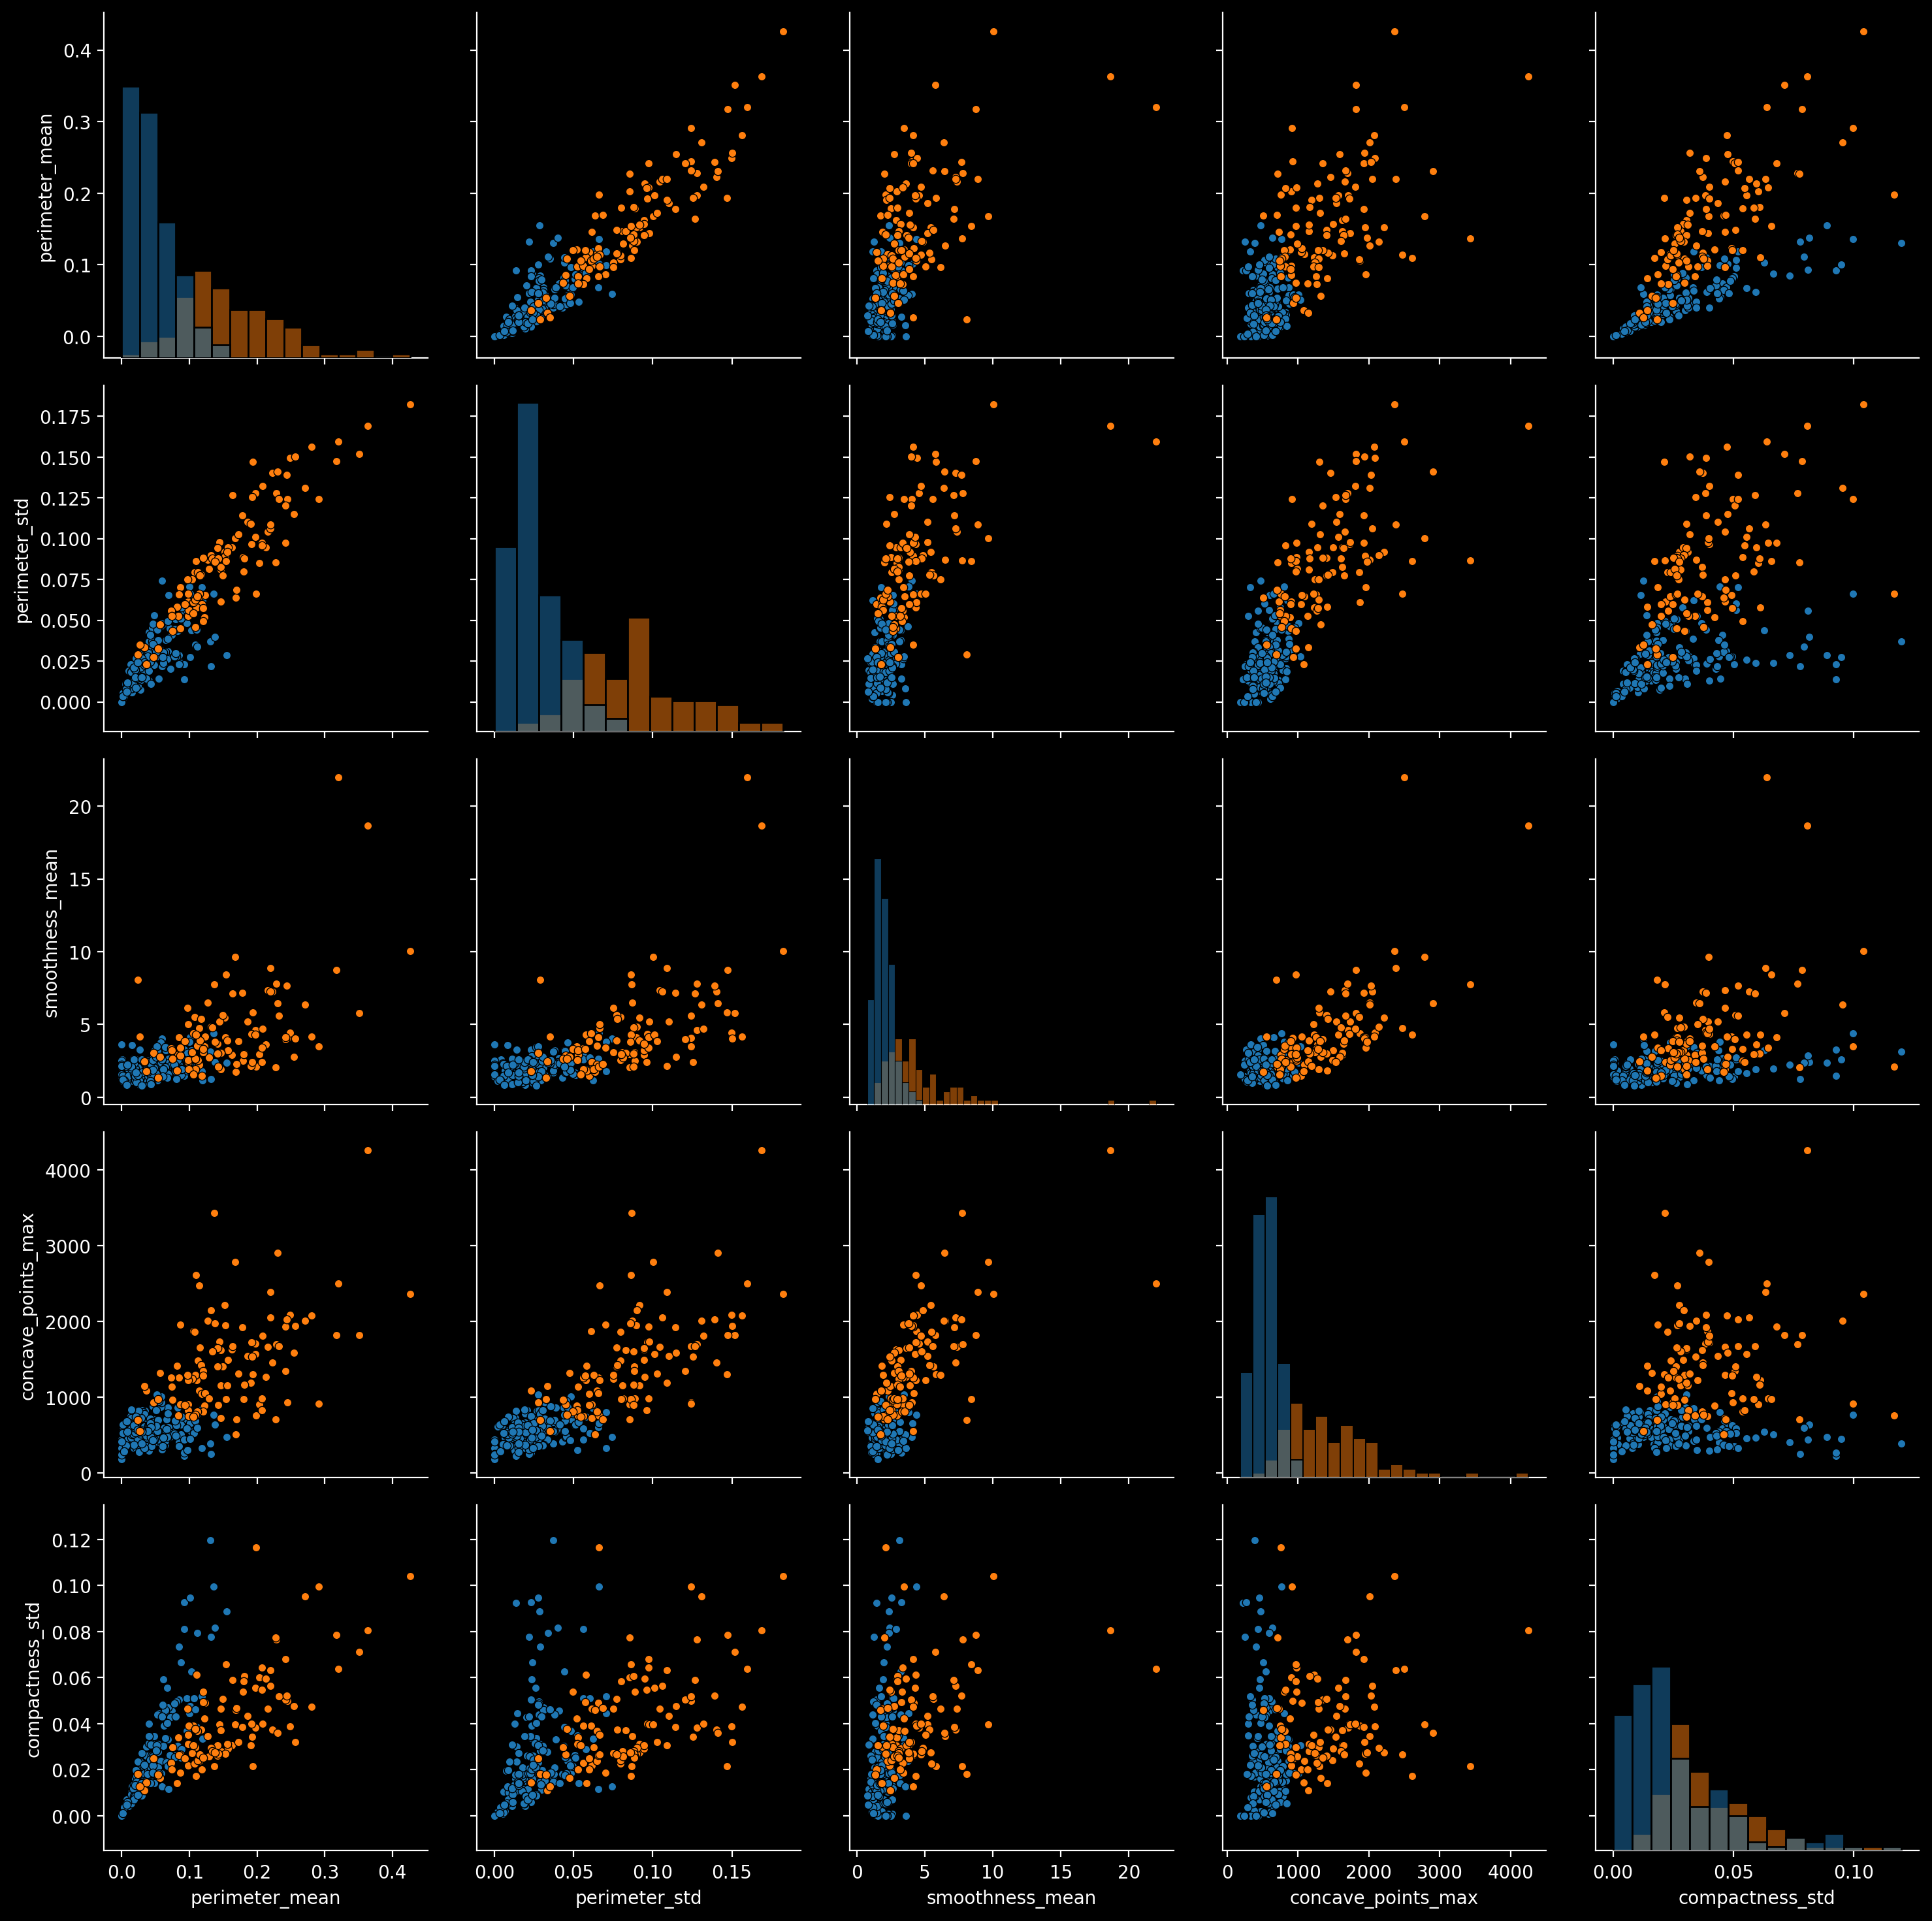

In [7]:
data = pd.concat([train.loc[:, best_features_ever], pd.Series(y, name='y')], axis=1)
g = sns.PairGrid(data[[data.columns[1],data.columns[2],data.columns[3],
                       data.columns[4], data.columns[5], 'y']], hue='y',
                 height=3)
g = g.map_diag(sns.histplot,edgecolor='k')
g = g.map_offdiag(plt.scatter, s = 20,linewidths=0.5, edgecolor='k')

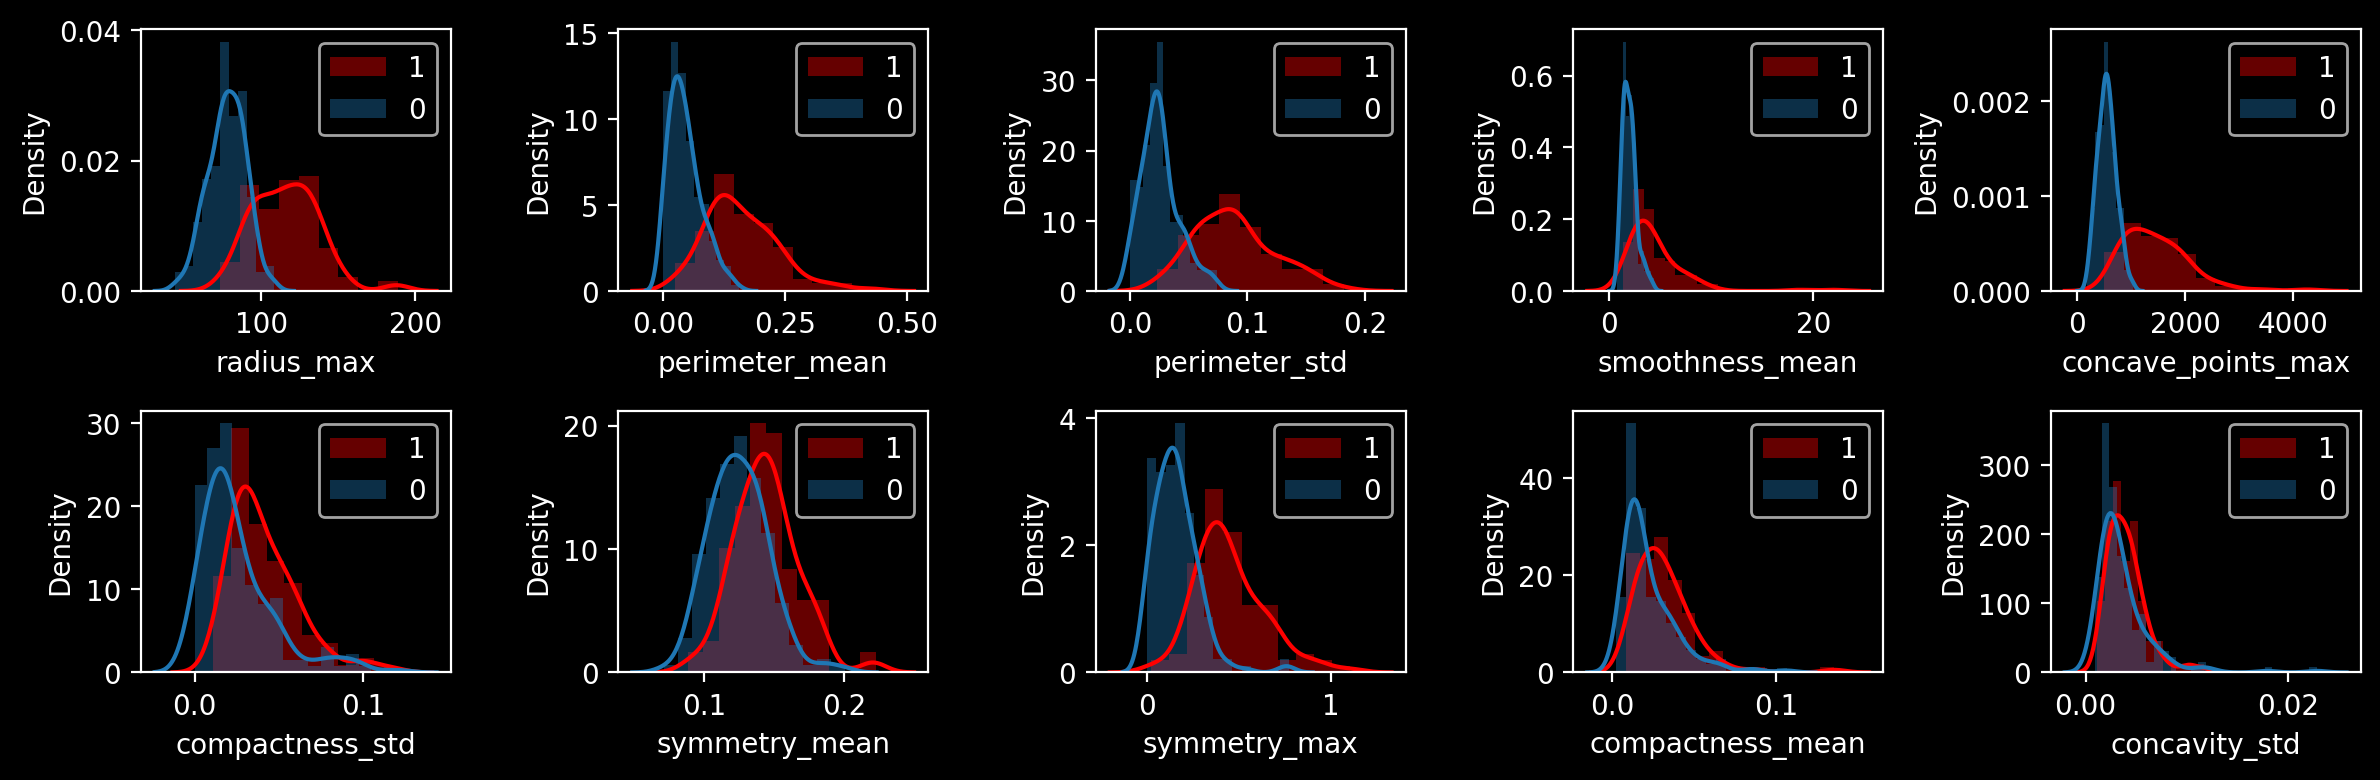

In [9]:
import warnings; warnings.filterwarnings('ignore')

fig, ax = plt.subplots(2, 5, figsize=(12,4))
axes = ax.ravel()
for i, feature in enumerate(best_features_ever):
    sns.distplot(data[data["y"] == 1][feature], label="1", hist_kws=dict(edgecolor=None, linewidth=1),ax=axes[i], color='r')
    sns.distplot(data[data["y"] == 0][feature], label="0", hist_kws=dict(edgecolor=None, linewidth=1),ax=axes[i])
    axes[i].legend()
plt.tight_layout()

### <b><span style='color:#686dec'>Модель : Baseline</span></b>

- Для базовой модель используем **деревье решении**, используем базовые настройки модели
- Разделяем выборку на тренировочную и тестовую подвыборку с соотношением 1/10

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
f1_score(dt.predict(X_test), y_test)

- Будем использовать `GridSearchCV` c 10 фолдами, из `parameter_grid` определим какая комбинация параметров даст нам наилучшию модель

In [ ]:
def optimize_model(model, param_grid):
    grid_search = GridSearchCV(model,
                              param_grid=param_grid,
                              cv=10)
    grid_search.fit(X_scaled, y)
    print("Best Score: {}".format(grid_search.best_score_))
    print("Best params: {}".format(grid_search.best_params_))
    return grid_search.best_estimator_

### <b><span style='color:#686dec'>Модель : RandomForest</span></b>

- Теперь пробуем используем модель которая использует RSS + Booststrap Agreggating енсембл; **случайный лес**
- Будем использовать `GridSearchCV` c 10 фолдами, из `parameter_grid` определим какая комбинация параметров даст нам наилучшию модель

In [10]:
parameter_grid = {'n_estimators': [20, 25, 30],
                  'max_depth': np.logspace(0,2,10),
                  'max_features': list(range(1,11))}
rf = optimize_model(RandomForestClassifier(), parameter_grid)

Best Score: 0.9614532019704433
Best params: {'max_depth': 7.742636826811269, 'max_features': 2, 'n_estimators': 30}


In [11]:
rf_test = RandomForestClassifier(**{'max_depth': 7.742636826811269, 
                                    'max_features': 10, 'n_estimators': 20, 'warm_start': True})
scaler = StandardScaler()
rf_test.fit(scaler.fit_transform(X_train), y_train)

RandomForestClassifier(max_depth=7.742636826811269, max_features=10,
                       n_estimators=20, warm_start=True)

In [37]:
y_pred = (rf_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

1.0

In [38]:
confusion_matrix(y_pred, y_test)

array([[21,  0],
       [ 0,  8]])

### <b><span style='color:#686dec'>Модель : Градиентного Бустинга</span></b>

- далее рассмотрим градиентнй бустинг

In [39]:
parameter_grid = {'n_estimators': [30, 50],
                  'max_depth': np.logspace(0,2,10),
                  'max_features': list(range(1,11)),
                  'learning_rate': np.logspace(0.001, 1, 10)}

gb = optimize_model(GradientBoostingClassifier(), 
                    parameter_grid)



Best Score: 0.9720443349753694
Best params: {'learning_rate': 1.0023052380778996, 'max_depth': 2.7825594022071245, 'max_features': 9, 'n_estimators': 50}


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [41]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                                     'max_depth': 2.7825594022071245, 
                                                     'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

GradientBoostingClassifier(learning_rate=1.0023052380778996,
                           max_depth=2.7825594022071245, max_features=7,
                           n_estimators=30)

In [12]:
y_pred = (gb_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

0.9508196721311476

In [13]:
confusion_matrix(y_pred, y_test)

array([[78,  5],
       [ 1, 58]])

### <b><span style='color:#686dec'>Подбор Фичей</span></b>

#### SelectKBest

Подбор самых важных фичей по методу `SelectKBest` с метрикой `chi2`

In [14]:
from sklearn.feature_selection import SelectKBest, chi2

In [15]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
best_chi2_feature_names = list(featureScores.nlargest(10,'Score')['Specs'])

In [16]:
best_chi2_feature_names

['concave_points_max',
 'texture_mean',
 'smoothness_std',
 'concave_points_std',
 'radius_max',
 'concavity_max',
 'smoothness_mean',
 'radius_mean',
 'concave_points_mean',
 'radius_std']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, best_chi2_feature_names], y, test_size=0.1)

In [18]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                        'max_depth': 2.7825594022071245, 
                                        'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

GradientBoostingClassifier(learning_rate=1.0023052380778996,
                           max_depth=2.7825594022071245, max_features=7,
                           n_estimators=30)

In [19]:
y_pred = (gb_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

0.9473684210526316

In [20]:
confusion_matrix(y_pred, y_test)

array([[19,  1],
       [ 0,  9]])

#### featureimportance_

Ииспользуя важность признаков по методу градиентного бустинга 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [22]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                        'max_depth': 2.7825594022071245, 
                                        'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

GradientBoostingClassifier(learning_rate=1.0023052380778996,
                           max_depth=2.7825594022071245, max_features=7,
                           n_estimators=30)

In [23]:
feat_importances = pd.Series(gb_test.feature_importances_, index=X.columns)
best_tree_feature_names = list(feat_importances.nlargest(10).index)

In [24]:
best_tree_feature_names

['concave_points_std',
 'perimeter_std',
 'area_max',
 'smoothness_std',
 'symmetry_max',
 'concavity_max',
 'radius_std',
 'fractal_dimension_max',
 'symmetry_std',
 'radius_max']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, best_tree_feature_names], y, test_size=0.5)

In [26]:
gb_test = GradientBoostingClassifier(**{'learning_rate': 1.0023052380778996, 
                                        'max_depth': 2.7825594022071245, 
                                        'max_features': 7, 'n_estimators': 30})
scaler = StandardScaler()
gb_test.fit(scaler.fit_transform(X_train), y_train)

GradientBoostingClassifier(learning_rate=1.0023052380778996,
                           max_depth=2.7825594022071245, max_features=7,
                           n_estimators=30)

In [27]:
y_pred = (gb_test.predict_proba(scaler.transform(X_test)) > 0.5).astype(int)[:, 1]
f1_score(y_pred, y_test)

0.923076923076923

In [28]:
confusion_matrix(y_pred, y_test)

array([[86,  5],
       [ 3, 48]])